#### 1. Importing necessary libraries

In [1]:
# %pip install numpy pandas sqlalchemy seaborn matplotlib ydata-profiling scikit-learn
%matplotlib inline

import numpy as np
import pandas as pd
import sqlite3
from sqlalchemy import create_engine
import seaborn as sns
from matplotlib import pyplot as plt
from ydata_profiling import ProfileReport
from scipy.stats import shapiro, anderson, expon, kstest
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

postgres_username = 'postgres'
postgres_password = 'password'
postgres_host = 'localhost'
postgres_port = '5432'
postgres_database = 'agrictrl'

engine = create_engine(f'postgresql://{postgres_username}:{postgres_password}@{postgres_host}:{postgres_port}/{postgres_database}')

#### 2. Extracting raw data

In [2]:
raw_df_pest = pd.read_csv('data/pesticides.csv')
raw_df_rain = pd.read_csv('data/rainfall.csv')
raw_df_temp = pd.read_csv('data/temp.csv')
raw_df_yield = pd.read_csv('data/yield.csv')

display(raw_df_pest.head())
display(raw_df_rain.head())
display(raw_df_temp.head())
display(raw_df_yield.head())

,Domain,Area,Element,Item,Year,Unit,Value
0,Pesticides Use,Albania,Use,Pesticides (total),1990,tonnes of active ingredients,121.0
1,Pesticides Use,Albania,Use,Pesticides (total),1991,tonnes of active ingredients,121.0
2,Pesticides Use,Albania,Use,Pesticides (total),1992,tonnes of active ingredients,121.0
3,Pesticides Use,Albania,Use,Pesticides (total),1993,tonnes of active ingredients,121.0
4,Pesticides Use,Albania,Use,Pesticides (total),1994,tonnes of active ingredients,201.0


,Area,Year,average_rain_fall_mm_per_year
0,Afghanistan,1985,327
1,Afghanistan,1986,327
2,Afghanistan,1987,327
3,Afghanistan,1989,327
4,Afghanistan,1990,327


,year,country,avg_temp
0,1849,Côte D'Ivoire,25.58
1,1850,Côte D'Ivoire,25.52
2,1851,Côte D'Ivoire,25.67
3,1852,Côte D'Ivoire,NaN
4,1853,Côte D'Ivoire,NaN


,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value
0,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1961,1961,hg/ha,14000
1,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1962,1962,hg/ha,14000
2,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1963,1963,hg/ha,14260
3,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1964,1964,hg/ha,14257
4,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1965,1965,hg/ha,14400


In [3]:
def print_dtypes(df, name):
    print(f"\n{name} dtypes:")
    print(df.dtypes)

print_dtypes(raw_df_pest, "raw_df_pest")
print_dtypes(raw_df_rain, "raw_df_rain")
print_dtypes(raw_df_temp, "raw_df_temp")
print_dtypes(raw_df_yield, "raw_df_yield")


raw_df_pest dtypes:
Domain      object
Area        object
Element     object
Item        object
Year         int64
Unit        object
Value      float64
dtype: object

raw_df_rain dtypes:
 Area                            object
Year                              int64
average_rain_fall_mm_per_year    object
dtype: object

raw_df_temp dtypes:
year          int64
country      object
avg_temp    float64
dtype: object

raw_df_yield dtypes:
Domain Code     object
Domain          object
Area Code        int64
Area            object
Element Code     int64
Element         object
Item Code        int64
Item            object
Year Code        int64
Year             int64
Unit            object
Value            int64
dtype: object


#### 3. Transform data

Column names are consistent and formatted


In [4]:
def format_columns(df):
    df.columns = df.columns.str.lower().str.strip().str.replace(' ', '_')
    return df

raw_df_pest = format_columns(raw_df_pest)
raw_df_rain = format_columns(raw_df_rain)
raw_df_temp = format_columns(raw_df_temp)
raw_df_yield = format_columns(raw_df_yield)

Entries with duplicate, null, and invalid data are removed

In [5]:
print(f"Shapes before cleaning")
print(f"raw_df_pest shape: {raw_df_pest.shape}")
print(f"raw_df_rain shape: {raw_df_rain.shape}")
print(f"raw_df_temp shape: {raw_df_temp.shape}")
print(f"raw_df_yield shape: {raw_df_yield.shape}")

Shapes before cleaning
raw_df_pest shape: (4349, 7)
raw_df_rain shape: (6727, 3)
raw_df_temp shape: (71311, 3)
raw_df_yield shape: (56717, 12)


In [6]:
# Upon inspection, raw_df_rain has values that are not numbers
raw_df_rain['average_rain_fall_mm_per_year'] = raw_df_rain['average_rain_fall_mm_per_year'].replace('..', np.nan)

# Upon inspection, raw_df_temp has multiple values per country and year
# Compute the average temperature for each country per year
raw_df_temp = raw_df_temp.groupby(['country', 'year']).mean().reset_index()

# General cleaning
def check_and_clean(df, name):
    
    print(f"{name} duplicates:", df.duplicated().sum())
    print(f"{name} null values:") 
    print(df.isnull().sum())

    df = df.drop_duplicates()
    df = df.dropna()
    
    print(f"{name} shape after cleaning:", df.shape)
    print()
    return df

raw_df_pest = check_and_clean(raw_df_pest, "raw_df_pest")
raw_df_rain = check_and_clean(raw_df_rain, "raw_df_rain")
raw_df_temp = check_and_clean(raw_df_temp, "raw_df_temp")
raw_df_yield = check_and_clean(raw_df_yield, "raw_df_yield")

raw_df_pest duplicates: 0
raw_df_pest null values:
domain     0
area       0
element    0
item       0
year       0
unit       0
value      0
dtype: int64
raw_df_pest shape after cleaning: (4349, 7)

raw_df_rain duplicates: 0
raw_df_rain null values:
area                               0
year                               0
average_rain_fall_mm_per_year    780
dtype: int64
raw_df_rain shape after cleaning: (5947, 3)

raw_df_temp duplicates: 0
raw_df_temp null values:
country        0
year           0
avg_temp    1035
dtype: int64
raw_df_temp shape after cleaning: (27479, 3)

raw_df_yield duplicates: 0
raw_df_yield null values:


domain_code     0
domain          0
area_code       0
area            0
element_code    0
element         0
item_code       0
item            0
year_code       0
year            0
unit            0
value           0
dtype: int64
raw_df_yield shape after cleaning: (56717, 12)



In [7]:
print(f"Shapes after cleaning:")
print(f"raw_df_pest shape: {raw_df_pest.shape}")
print(f"raw_df_rain shape: {raw_df_rain.shape}")
print(f"raw_df_temp shape: {raw_df_temp.shape}")
print(f"raw_df_yield shape: {raw_df_yield.shape}")

Shapes after cleaning:
raw_df_pest shape: (4349, 7)
raw_df_rain shape: (5947, 3)
raw_df_temp shape: (27479, 3)
raw_df_yield shape: (56717, 12)


Columns have appropriate data types

In [8]:
raw_df_rain['average_rain_fall_mm_per_year'] = raw_df_rain['average_rain_fall_mm_per_year'].astype('float64')

Normalization of data to organize entities

In [9]:
# Normalization of tables
df_country = raw_df_yield[['area_code', 'area']].drop_duplicates().reset_index(drop=True)
df_country = df_country.rename(columns={'area_code': 'country_code', 'area': 'country'})
df_item = raw_df_yield[['item_code', 'item']].drop_duplicates().reset_index(drop=True)

# Domain and Element are dropped due to unneeded context
# Context is already provided by the tables
df_yield = raw_df_yield.copy()
df_yield = df_yield.drop(columns=['domain', 'domain_code', 'element', 'element_code', 'area', 'element', 'item', 'year_code', 'unit'])
df_yield = df_yield.rename(columns={'area_code': 'country_code', 'value': 'hg/ha_yield'})

# Item in raw_df_pest is the same for all (Pesticide)
# Rename value to have unit measurement
df_pest = raw_df_pest.copy()
df_pest = df_pest.drop(columns=['domain', 'element', 'item', 'unit'])
df_pest = df_pest.rename(columns={'area': 'country', 'value': 'pesticides_tonnes'})
df_pest = df_country.merge(df_pest, on='country', how='inner')
df_pest = df_pest.drop(columns=['country'])

# Normalize raw_df_rain
df_rain = raw_df_rain.copy()
df_rain = df_rain.rename(columns={'area': 'country', 'average_rain_fall_mm_per_year': 'avg_rainfall_mm'})
df_rain = df_country.merge(df_rain, on='country', how='inner')
df_rain = df_rain.drop(columns=['country'])

# Normalize raw_df_temp
df_temp = raw_df_temp.copy()
df_temp = df_temp.rename(columns={'avg_temp': 'avg_temp_celsius'})
df_temp = df_country.merge(df_temp, on='country', how='inner')
df_temp = df_temp.drop(columns=['country'])

print(f"Shapes after normalization:")
print(f"df_pest shape: {df_pest.shape}")
print(f"df_rain shape: {df_rain.shape}")
print(f"df_temp shape: {df_temp.shape}")
print(f"df_yield shape: {df_yield.shape}")

# Display normalized tables
display(df_country.head())
display(df_item.head())
display(df_yield.head())
display(df_pest.head())
display(df_rain.head())
display(df_temp.head())

Shapes after normalization:
df_pest shape: (4322, 3)
df_rain shape: (4986, 3)
df_temp shape: (23644, 3)
df_yield shape: (56717, 4)


,country_code,country
0,2,Afghanistan
1,3,Albania
2,4,Algeria
3,5,American Samoa
4,7,Angola


,item_code,item
0,56,Maize
1,116,Potatoes
2,27,"Rice, paddy"
3,15,Wheat
4,83,Sorghum


,country_code,item_code,year,hg/ha_yield
0,2,56,1961,14000
1,2,56,1962,14000
2,2,56,1963,14260
3,2,56,1964,14257
4,2,56,1965,14400


,country_code,year,pesticides_tonnes
0,3,1990,121.0
1,3,1991,121.0
2,3,1992,121.0
3,3,1993,121.0
4,3,1994,201.0


,country_code,year,avg_rainfall_mm
0,2,1985,327.0
1,2,1986,327.0
2,2,1987,327.0
3,2,1989,327.0
4,2,1990,327.0


,country_code,year,avg_temp_celsius
0,2,1833,13.91
1,2,1834,13.91
2,2,1835,14.71
3,2,1837,15.47
4,2,1838,18.50


In [10]:
print_dtypes(df_country, "df_country")
print_dtypes(df_item, "df_item")
print_dtypes(df_yield, "df_yield")
print_dtypes(df_pest, "df_pest")
print_dtypes(df_rain, "df_rain")
print_dtypes(df_temp, "df_temp")


df_country dtypes:
country_code     int64
country         object
dtype: object

df_item dtypes:
item_code     int64
item         object
dtype: object

df_yield dtypes:
country_code    int64
item_code       int64
year            int64
hg/ha_yield     int64
dtype: object

df_pest dtypes:
country_code           int64
year                   int64
pesticides_tonnes    float64
dtype: object

df_rain dtypes:
country_code         int64
year                 int64
avg_rainfall_mm    float64
dtype: object

df_temp dtypes:
country_code          int64
year                  int64
avg_temp_celsius    float64
dtype: object


#### 4. Loading transformed data into PostgreSQL

In [11]:
df_country.to_sql('Country', engine, schema='public', if_exists='replace', index=False)
df_item.to_sql('Item', engine, schema='public', if_exists='replace', index=False)
df_yield.to_sql('Yield', engine, schema='public', if_exists='replace', index=False)
df_pest.to_sql('PesticideUse', engine, schema='public', if_exists='replace', index=False)
df_rain.to_sql('Rainfall', engine, schema='public', if_exists='replace', index=False)
df_temp.to_sql('Temperature', engine, schema='public', if_exists='replace', index=False)

644

#### 5. Analyze data
- Data analysis on Yields based on time, rainfall, temperature, and pesticide use


Materialized View stored in SQLite

In [12]:
query = """
SELECT c.country, i.item, y.year, p.pesticides_tonnes, r.avg_rainfall_mm, t.avg_temp_celsius, y."hg/ha_yield"
FROM public."Yield" y
JOIN public."Country" c ON y.country_code = c.country_code
JOIN public."Item" i ON y.item_code = i.item_code
JOIN public."PesticideUse" p ON y.country_code = p.country_code AND y.year = p.year
JOIN public."Rainfall" r ON y.country_code = r.country_code AND y.year = r.year
JOIN public."Temperature" t ON y.country_code = t.country_code AND y.year = t.year
"""

df = pd.read_sql(query, engine)
display(df.head())
display(df.shape)

# Save materliazed view to SQLite
conn = sqlite3.connect('agrictrl.db')
df.to_sql('agrictrl', conn, if_exists='replace', index=False)
conn.close()

,country,item,year,pesticides_tonnes,avg_rainfall_mm,avg_temp_celsius,hg/ha_yield
0,Slovenia,Wheat,2010,1134.37,1162.0,10.00,48044
1,Slovenia,Wheat,2009,1162.87,1162.0,11.06,39643
2,Slovenia,Wheat,2008,1218.15,1162.0,11.09,45265
3,Slovenia,Wheat,2007,1155.23,1162.0,11.31,41616
4,Slovenia,Wheat,2006,1280.98,1162.0,10.56,41907


(13130, 7)

Data Checking

In [13]:
# Read dataframe from SQLite database
conn = sqlite3.connect('agrictrl.db')
df = pd.read_sql('SELECT * FROM agrictrl', conn)
conn.close()

display(df.head())
display(df.shape)

,country,item,year,pesticides_tonnes,avg_rainfall_mm,avg_temp_celsius,hg/ha_yield
0,Slovenia,Wheat,2010,1134.37,1162.0,10.00,48044
1,Slovenia,Wheat,2009,1162.87,1162.0,11.06,39643
2,Slovenia,Wheat,2008,1218.15,1162.0,11.09,45265
3,Slovenia,Wheat,2007,1155.23,1162.0,11.31,41616
4,Slovenia,Wheat,2006,1280.98,1162.0,10.56,41907


(13130, 7)

In [14]:
df.dtypes

country               object
item                  object
year                   int64
pesticides_tonnes    float64
avg_rainfall_mm      float64
avg_temp_celsius     float64
hg/ha_yield            int64
dtype: object

In [15]:
df.describe()

,year,pesticides_tonnes,avg_rainfall_mm,avg_temp_celsius,hg/ha_yield
count,13130.000000,13130.000000,13130.000000,13130.000000,13130.000000
mean,2001.622772,14838.697886,1157.238766,19.836531,70968.615461
std,7.033139,33652.454670,743.622488,6.658083,79124.283809
min,1990.000000,0.040000,51.000000,1.300000,50.000000
25%,1995.000000,264.530000,608.000000,15.670000,18000.000000
50%,2001.000000,2172.200000,1083.000000,20.620000,39543.500000
75%,2008.000000,13335.220000,1651.000000,25.780000,97152.250000
max,2013.000000,367778.000000,3240.000000,30.420000,501412.000000


In [16]:
target_column = 'hg/ha_yield'
measured_columns = ['hg/ha_yield', 'avg_rainfall_mm', 'pesticides_tonnes', 'avg_temp_celsius']
entity_columns = ['country', 'item']
time_columns = ['year']

Data Queries

In [17]:
query = """
SELECT item, COUNT(*) as count
FROM agrictrl
GROUP BY item
ORDER BY count DESC
"""

conn = sqlite3.connect('agrictrl.db')
result = pd.read_sql(query, conn)
conn.close()

print("Crops:")
print(result)

Crops:
                   item  count
0              Potatoes   2091
1                 Maize   2028
2                 Wheat   1810
3           Rice, paddy   1502
4               Sorghum   1435
5              Soybeans   1242
6        Sweet potatoes   1163
7               Cassava    941
8  Plantains and others    464
9                  Yams    454


In [18]:
query = "SELECT COUNT(DISTINCT country) as unique_countries FROM agrictrl"
conn = sqlite3.connect('agrictrl.db')
result = pd.read_sql(query, conn)
conn.close()

print("Countries:", result['unique_countries'][0])

Countries: 101


In [19]:
query = """
SELECT country, SUM("hg/ha_yield") as total_yield
FROM agrictrl
GROUP BY country
ORDER BY total_yield DESC
LIMIT 10
"""

conn = sqlite3.connect('agrictrl.db')
result = pd.read_sql(query, conn)
conn.close()

print("Top 10 countries by yield:")
print(result)

Top 10 countries by yield:
       country  total_yield
0        Japan     20745152
1      Jamaica     19698007
2        Egypt     18414424
3    Australia     18185177
4  New Zealand     17657728
5  El Salvador     16855944
6    Guatemala     16508723
7    Argentina     16432016
8       Mexico     16348566
9        Italy     16140350


In [20]:
query = """
SELECT item, country, SUM("hg/ha_yield") as total_yield
FROM agrictrl
GROUP BY item, country
ORDER BY total_yield DESC
LIMIT 10
"""

conn = sqlite3.connect('agrictrl.db')
result = pd.read_sql(query, conn)
conn.close()

print("Top 10 countries and items by yield:")
print(result)

Top 10 countries and items by yield:
       item         country  total_yield
0  Potatoes     New Zealand     10032090
1  Potatoes     Netherlands      9971625
2  Potatoes  United Kingdom      9341029
3  Potatoes     Switzerland      9218605
4  Potatoes          France      9085857
5  Potatoes         Germany      8890727
6  Potatoes         Denmark      8848101
7  Potatoes       Australia      7611731
8  Potatoes          Sweden      7265332
9  Potatoes           Japan      7153121



Top 10 countries by yield for Wheat:
          country  total_yield
0         Ireland      1953154
1     Netherlands      1908372
2  United Kingdom      1742969
3         Germany      1659152
4         Denmark      1635917
5          France      1592215
6     New Zealand      1534948
7           Egypt      1378987
8          Zambia      1376512
9          Sweden      1355321


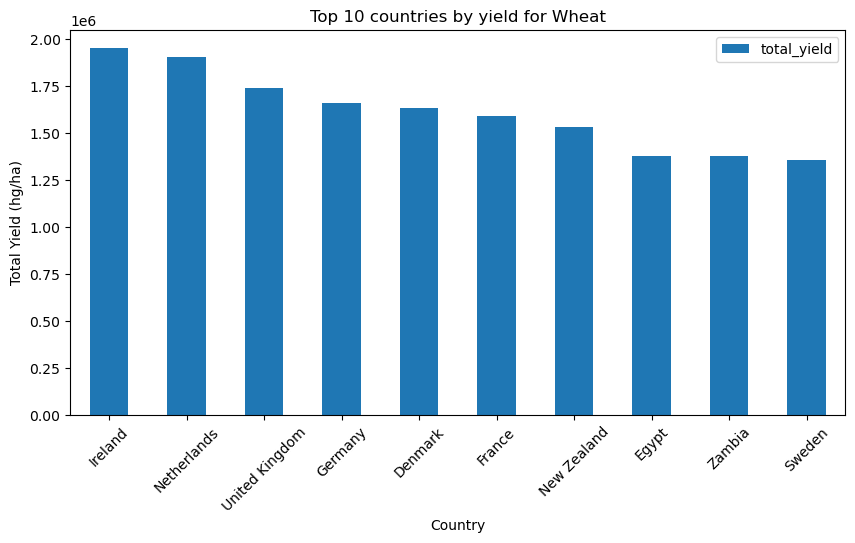


Top 10 countries by yield for Rice, paddy:
       country  total_yield
0        Egypt      2052398
1    Australia      1983077
2       Greece      1695021
3        Spain      1616431
4      Uruguay      1487097
5         Peru      1477600
6        Japan      1475175
7       Turkey      1453562
8        Italy      1417217
9  El Salvador      1330141


<Figure size 640x480 with 0 Axes>

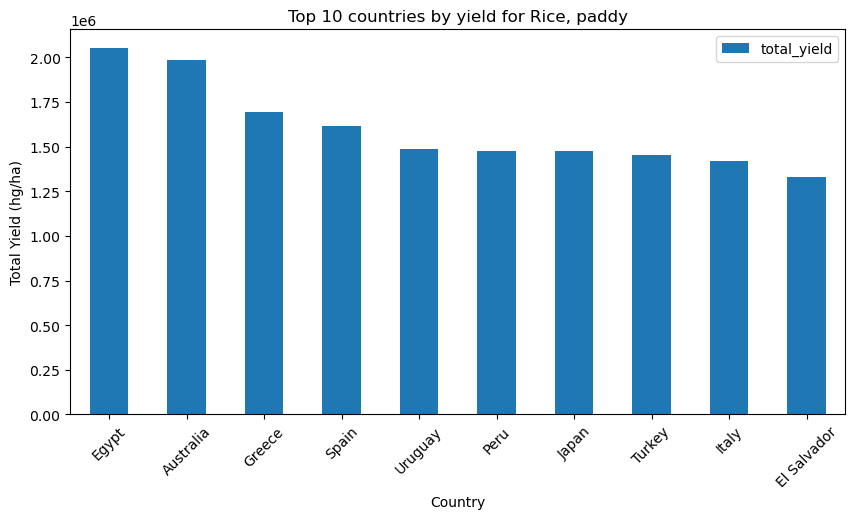


Top 10 countries by yield for Maize:
       country  total_yield
0        Qatar      3141639
1  New Zealand      2359363
2       Greece      2318515
3        Chile      2240626
4  Netherlands      2206436
5      Austria      2173173
6  Switzerland      2133962
7        Spain      2087698
8        Italy      2067578
9      Germany      1984819


<Figure size 640x480 with 0 Axes>

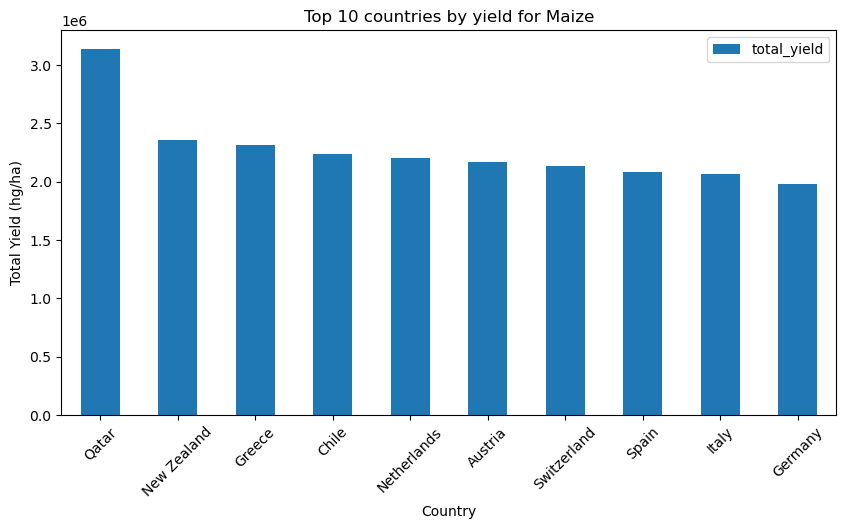


Top 10 countries by yield for Sorghum:
     country  total_yield
0      Italy      1364940
1     France      1322776
2      Egypt      1221907
3    Algeria      1181995
4      Spain      1004673
5  Argentina       977996
6    Uruguay       808183
7       Peru       798170
8    Croatia       790762
9   Colombia       787971


<Figure size 640x480 with 0 Axes>

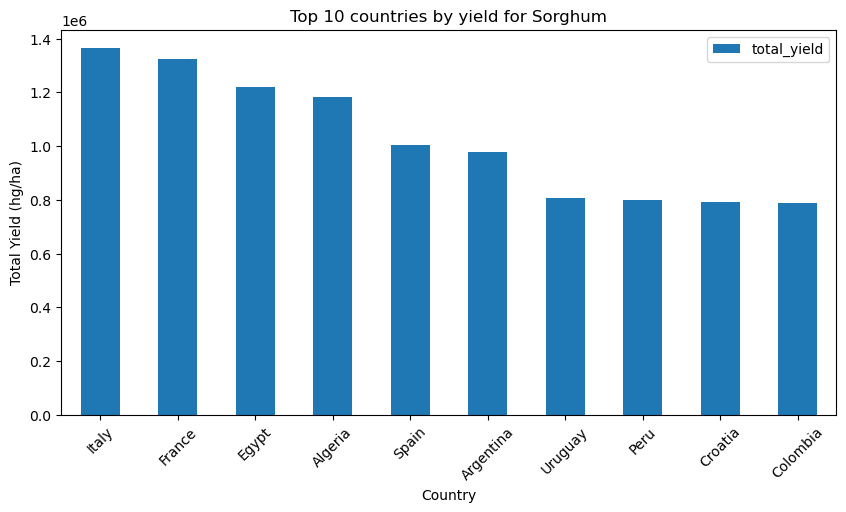


Top 10 countries by yield for Potatoes:
          country  total_yield
0     New Zealand     10032090
1     Netherlands      9971625
2  United Kingdom      9341029
3     Switzerland      9218605
4          France      9085857
5         Germany      8890727
6         Denmark      8848101
7       Australia      7611731
8          Sweden      7265332
9           Japan      7153121


<Figure size 640x480 with 0 Axes>

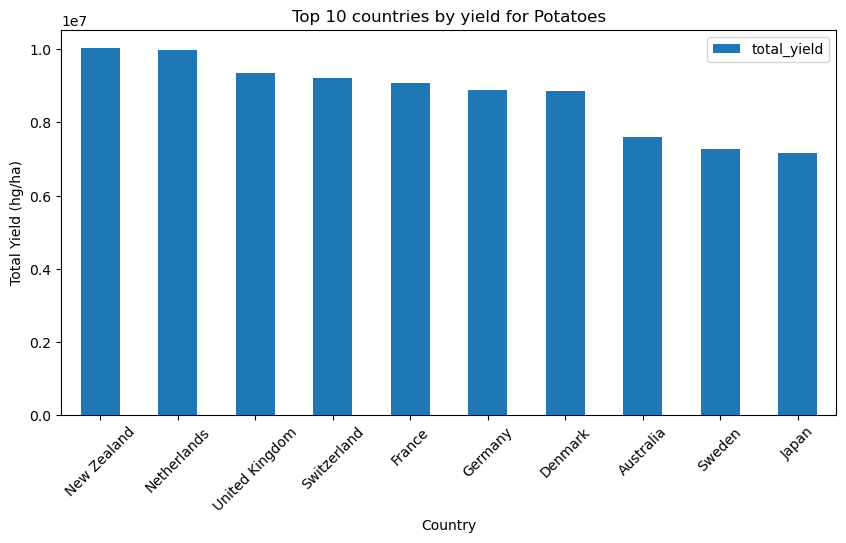


Top 10 countries by yield for Sweet potatoes:
     country  total_yield
0      Egypt      6011495
1  Australia      5925049
2      Japan      5465706
3     Mexico      4476074
4     Greece      4325831
5      Italy      4229447
6      Spain      3945575
7    Morocco      3903215
8    Senegal      3844977
9       Peru      3775661


<Figure size 640x480 with 0 Axes>

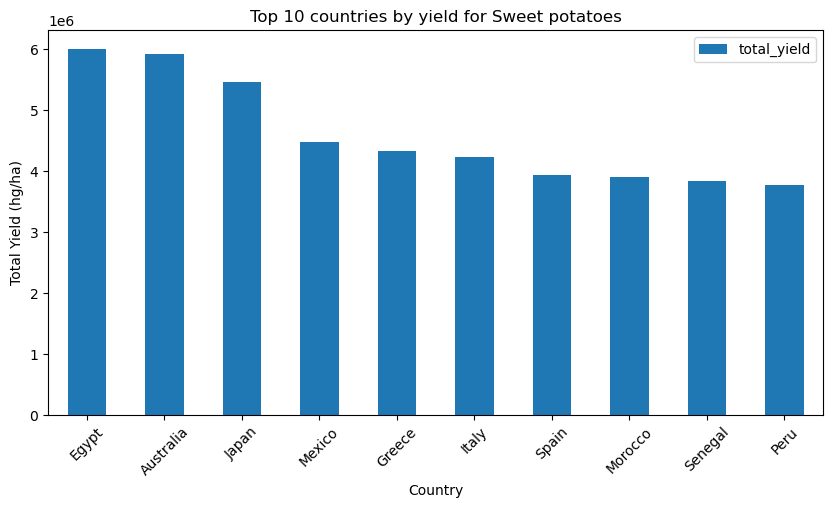


Top 10 countries by yield for Cassava:
       country  total_yield
0        India      6491392
1     Suriname      4399497
2      Jamaica      4172058
3     Thailand      4003240
4        Niger      3553448
5     Malaysia      3530075
6    Indonesia      3447743
7    Mauritius      3316990
8  El Salvador      3243092
9       Brazil      3061021


<Figure size 640x480 with 0 Axes>

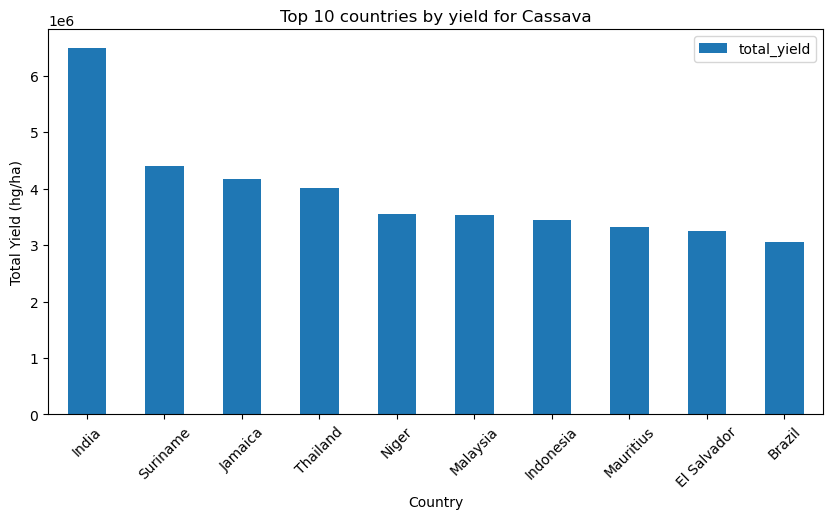


Top 10 countries by yield for Yams:
            country  total_yield
0             Japan      4860899
1  Papua New Guinea      3967987
2           Jamaica      3661155
3          Portugal      3198138
4              Mali      3072613
5             Ghana      2984539
6         Nicaragua      2925116
7            Guinea      2573256
8          Colombia      2468265
9            Brazil      2133823


<Figure size 640x480 with 0 Axes>

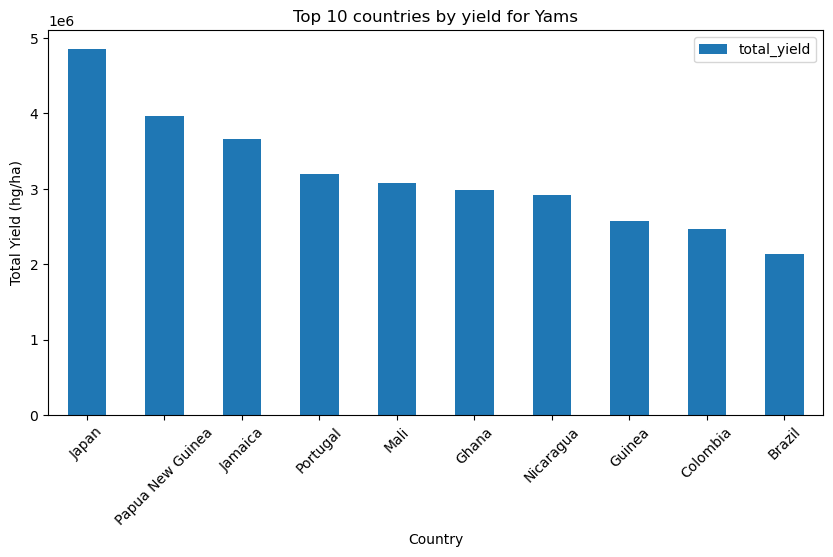


Top 10 countries by yield for Soybeans:
       country  total_yield
0        Italy       792274
1       Turkey       698931
2        Egypt       675168
3  Switzerland       638731
4    Guatemala       637155
5       Canada       600943
6       France       592469
7      Austria       558562
8       Brazil       555786
9    Argentina       550638


<Figure size 640x480 with 0 Axes>

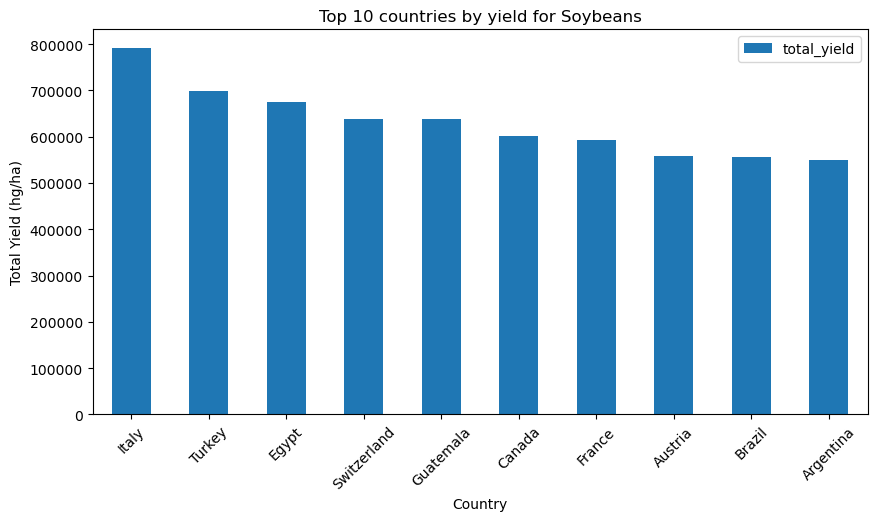


Top 10 countries by yield for Plantains and others:
              country  total_yield
0           Guatemala      6695215
1            Suriname      5841239
2         El Salvador      4567920
3             Jamaica      3936941
4               Kenya      2848219
5                Peru      2782993
6           Sri Lanka      2750833
7            Honduras      2735904
8  Dominican Republic      2445659
9           Nicaragua      2311282


<Figure size 640x480 with 0 Axes>

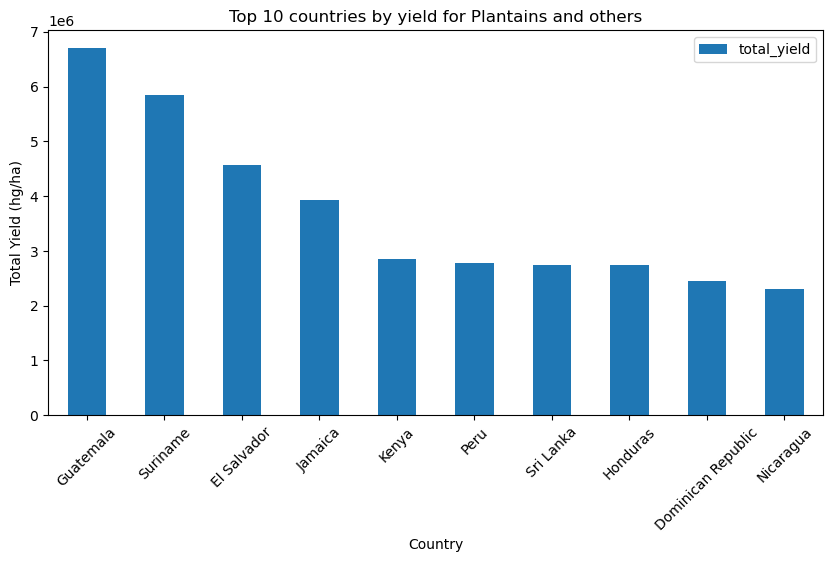

<Figure size 640x480 with 0 Axes>

In [21]:
conn = sqlite3.connect('agrictrl.db')

for item in df['item'].unique():
    query = f"""
    SELECT country, SUM("hg/ha_yield") as total_yield
    FROM agrictrl
    WHERE item = '{item}'
    GROUP BY country
    ORDER BY total_yield DESC
    LIMIT 10
    """
    top_10_countries = pd.read_sql(query, conn)
    
    print(f"\nTop 10 countries by yield for {item}:")
    print(top_10_countries)
    
    top_10_countries.plot(kind='bar', x='country', y='total_yield', figsize=(10, 5))
    plt.title(f'Top 10 countries by yield for {item}')
    plt.xlabel('Country')
    plt.ylabel('Total Yield (hg/ha)')
    plt.xticks(rotation=45)
    plt.show()
    plt.tight_layout()

conn.close()

In [22]:
print("Top 10 countries in pesticide usage:")
print(df.groupby('country')['pesticides_tonnes'].sum().nlargest(10))
print()
print("Top 10 countries with lowest pesticide usage:")
print(df.groupby('country')['pesticides_tonnes'].sum().nsmallest(10))

Top 10 countries in pesticide usage:
country
Brazil       39275532.00
Italy        12908319.20
Argentina    12499020.64
France       11762903.28
Japan        11315960.25
Colombia     10966384.53
India         8916463.36
Mexico        7980062.00
Thailand      6353732.00
Spain         6194363.00
Name: pesticides_tonnes, dtype: float64

Top 10 countries with lowest pesticide usage:
country
Bahrain                      376.69
Montenegro                   888.60
Botswana                    1094.00
Eritrea                     1788.36
Central African Republic    2899.33
Lesotho                     2999.56
Qatar                       3060.00
Haiti                       4146.56
Mali                        4362.39
Namibia                     4475.00
Name: pesticides_tonnes, dtype: float64


In [23]:
for column in measured_columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]

    outliers_count_per_country = outliers['country'].value_counts().rename('count')
    outliers_avg_per_country = outliers.groupby('country')[column].mean().rename('average')
    
    outliers_per_country = pd.concat([outliers_count_per_country, outliers_avg_per_country], axis=1)
    
    print(f"Summary of {column} outliers for each country:")
    display(outliers_per_country)
    print()


Summary of hg/ha_yield outliers for each country:


,count,average
country,,
Japan,55,267143.854545
Australia,39,321014.384615
Egypt,37,261876.972973
New Zealand,28,402464.142857
Guatemala,27,317554.407407
Italy,27,240112.333333
India,25,278335.480000
Suriname,25,265264.280000
Norway,23,249091.739130



Summary of avg_rainfall_mm outliers for each country:


,count,average
country,,
Colombia,207,3240.0



Summary of pesticides_tonnes outliers for each country:


,count,average
country,,
Brazil,207,189736.869565
Japan,161,70285.467391
Italy,161,80175.895652
Mexico,160,46175.571500
India,160,52197.140500
Argentina,144,79308.810000
France,138,85238.429565
Colombia,135,72133.370667
Spain,133,40240.315789



Summary of avg_temp_celsius outliers for each country:


,count,average
country,,


Pandas Profiling

In [24]:
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
profile.to_file("output.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Bar Graph Distribution

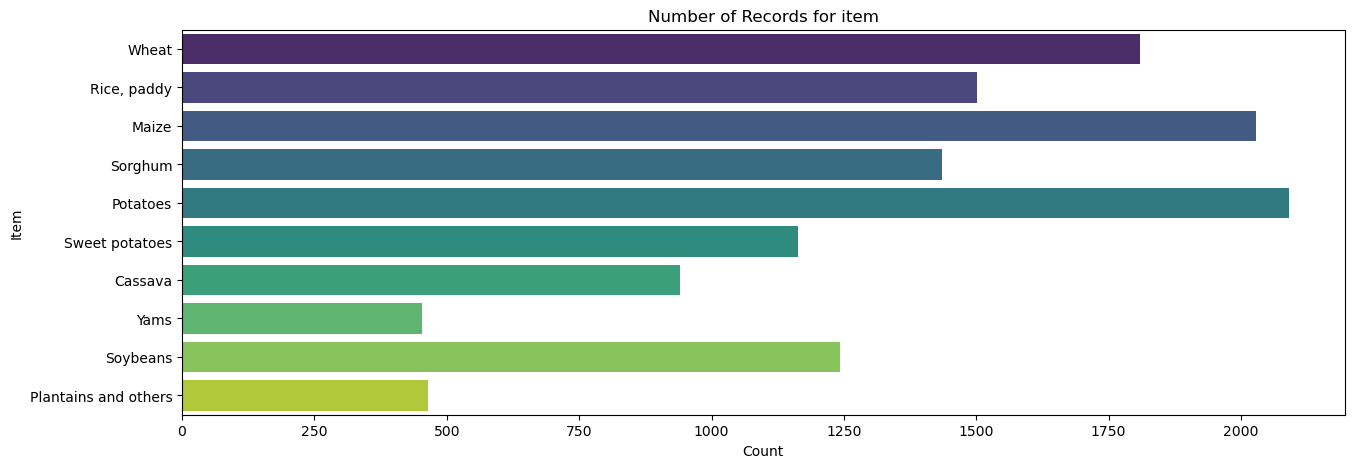

In [25]:
# Number of Records per Item
plt.figure(figsize=(15, 5))
sns.countplot(data=df, y='item', hue='item', palette='viridis')
plt.title('Number of Records for item')
plt.xlabel('Count')
plt.ylabel('Item')
plt.show()

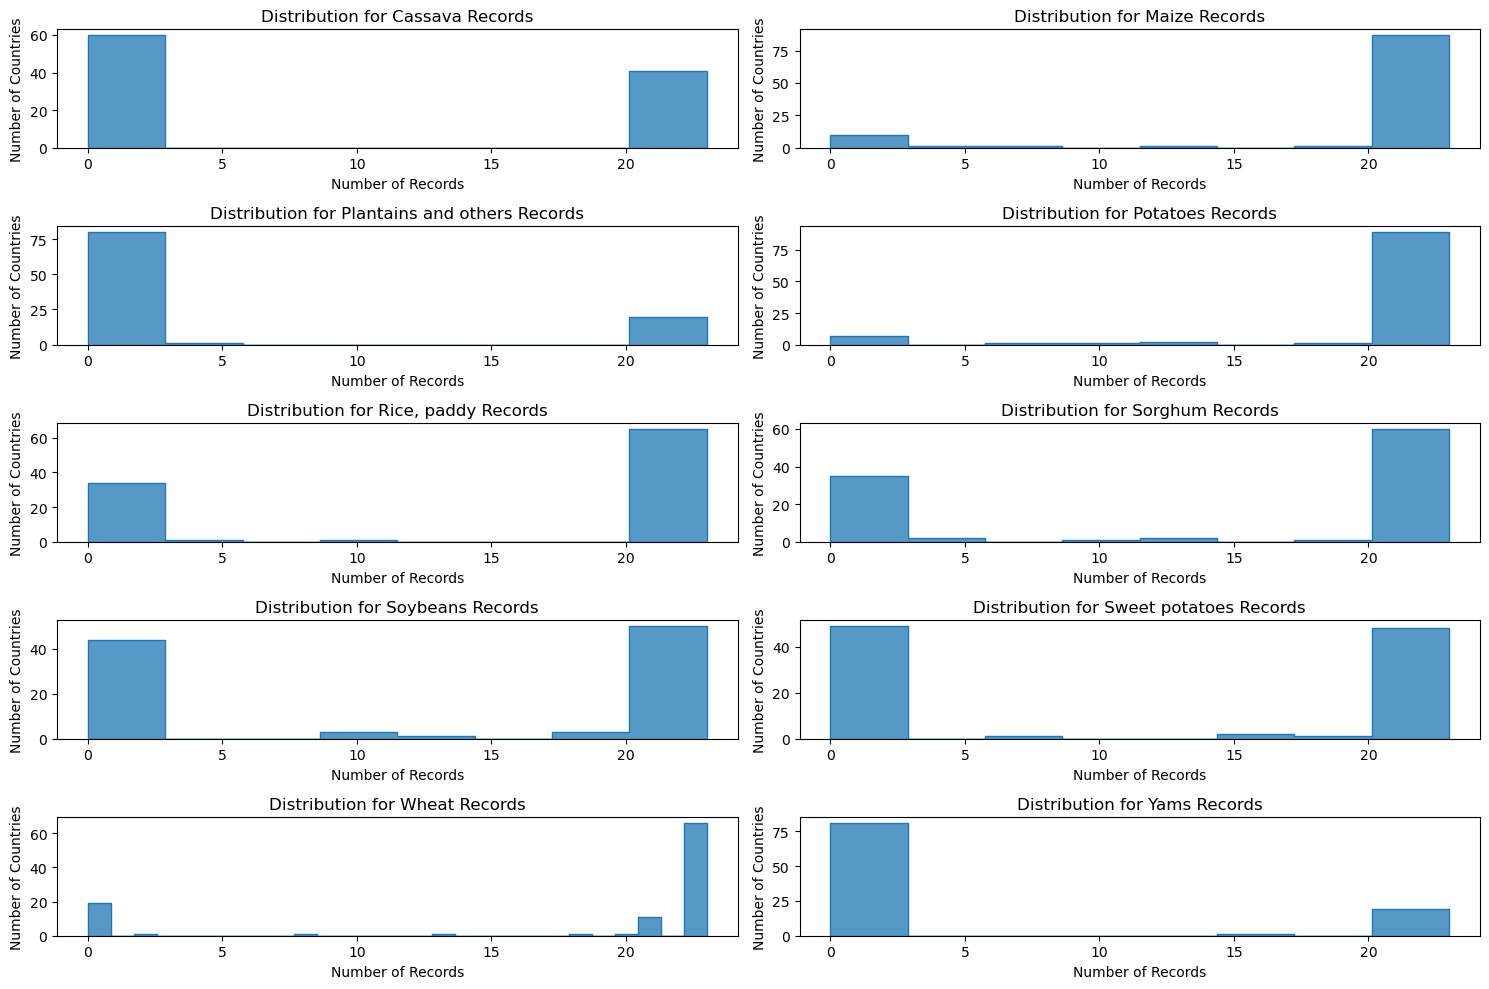

In [26]:
# Count the number of records per country and item
item_country_record_counts = df.groupby(['item', 'country']).size().unstack(fill_value=0)

# Plot the distribution of the number of records per country for each item
plt.figure(figsize=(15, 10))
for i, item in enumerate(item_country_record_counts.index, 1):
    plt.subplot(5, 2, i)
    sns.histplot(item_country_record_counts.loc[item], kde=False, element='step')
    plt.title(f'Distribution for {item} Records')
    plt.xlabel('Number of Records')
    plt.ylabel('Number of Countries')

plt.tight_layout()
plt.show()


Data Distribution

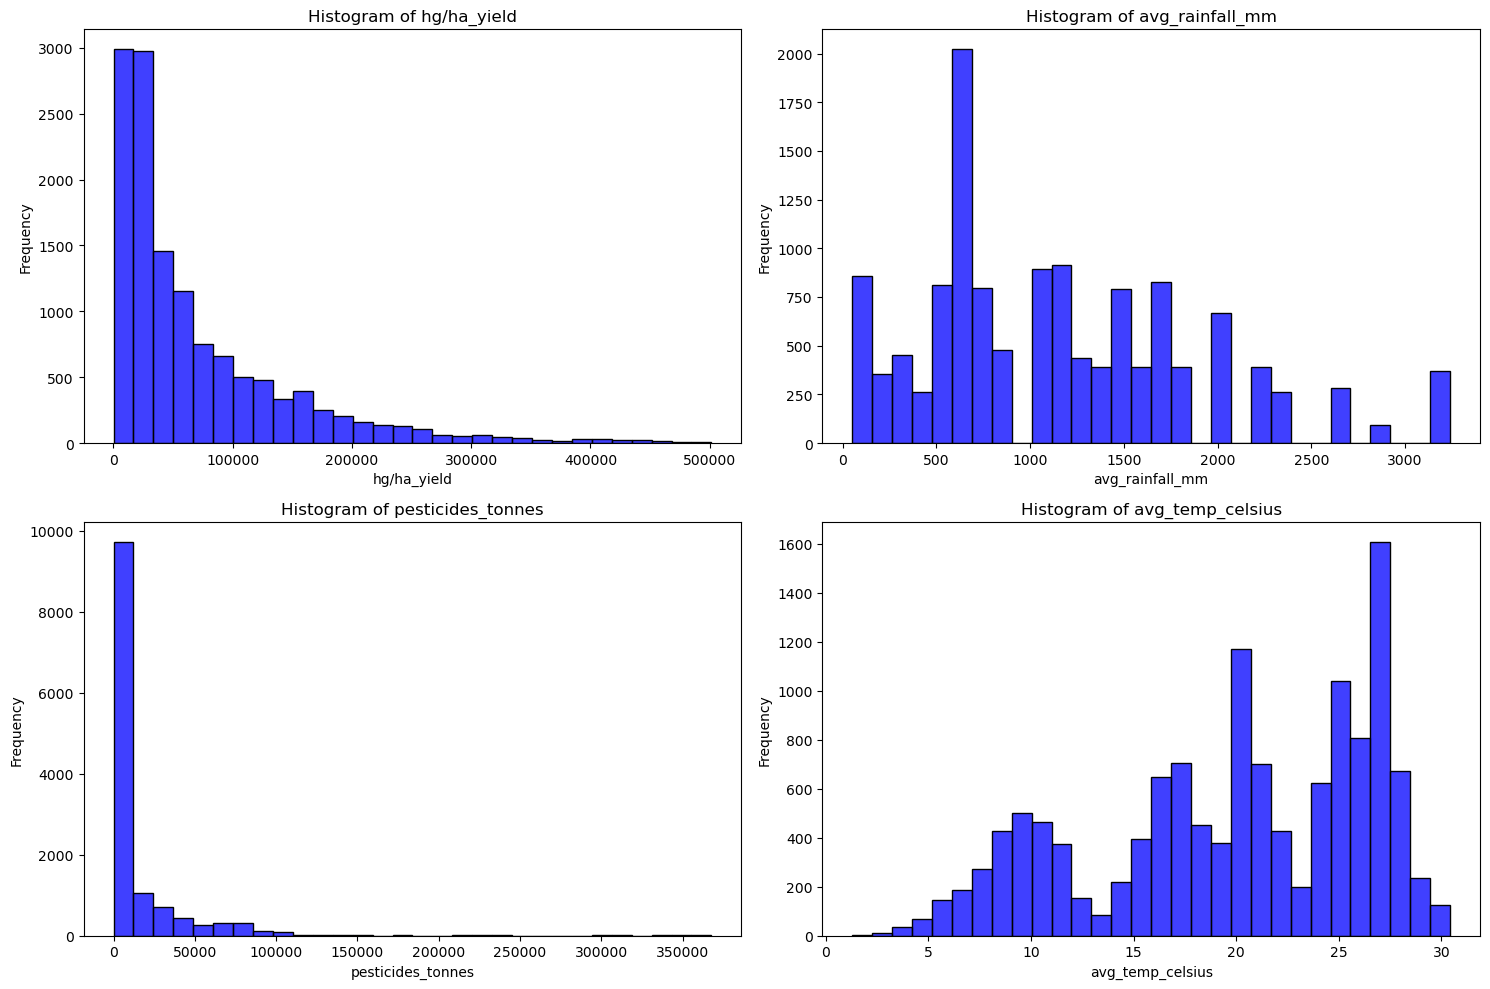

In [27]:
plt.figure(figsize=(15, 10))

for i, column in enumerate(measured_columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[column], bins=30, kde=False, color='blue')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Box Plot

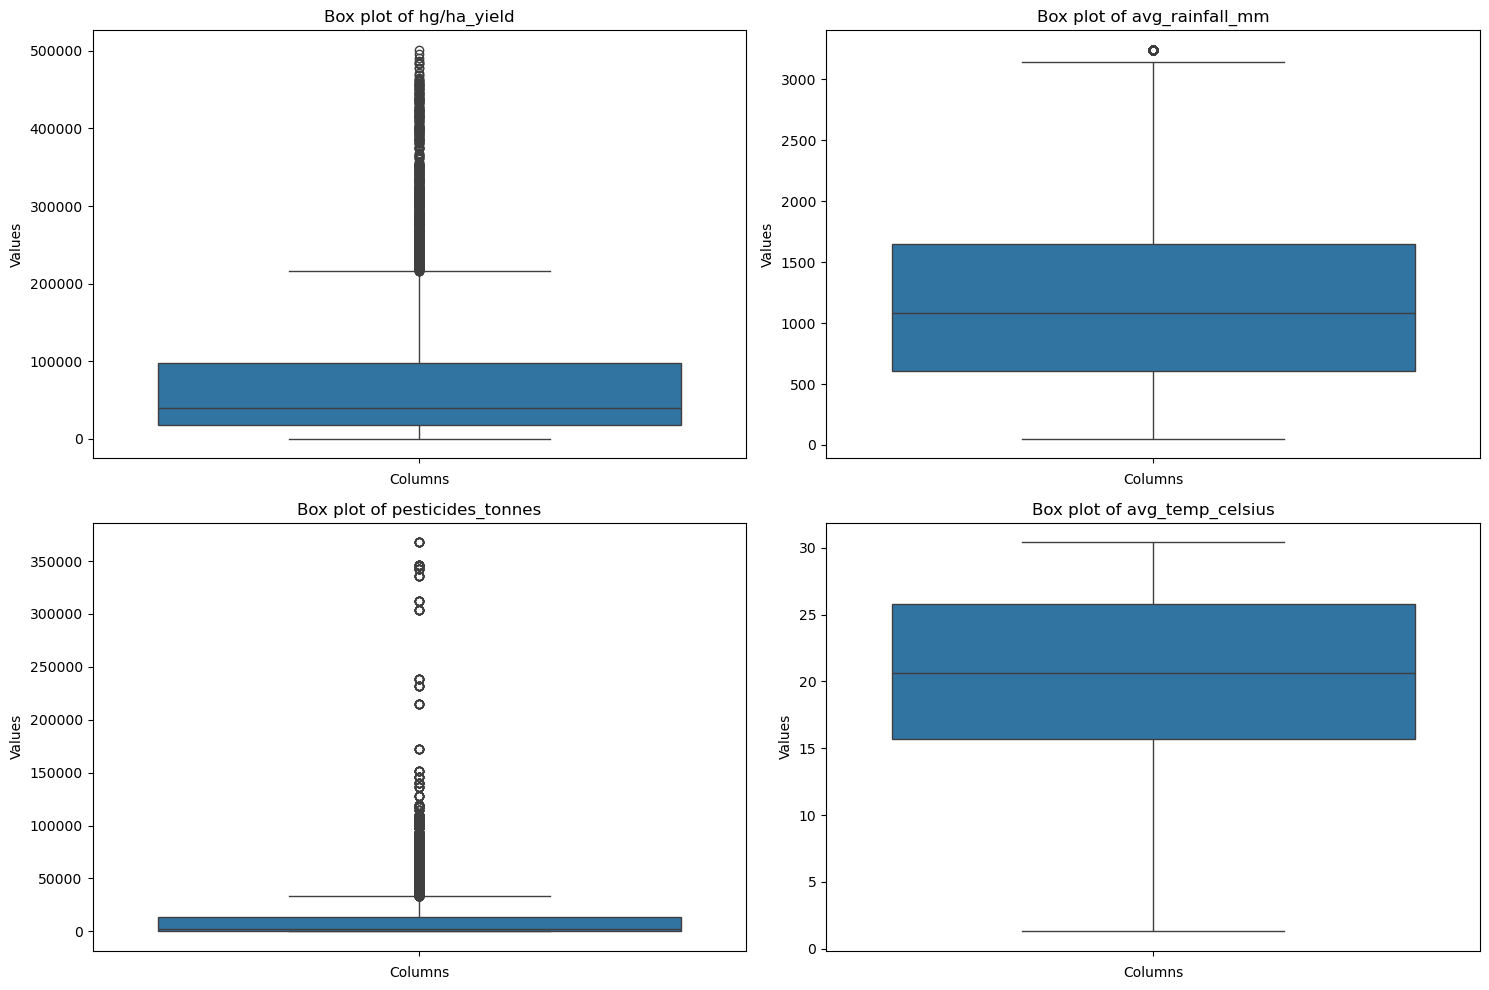

In [28]:
plt.figure(figsize=(15, 10))

for i, column in enumerate(measured_columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df[column])
    plt.title(f'Box plot of {column}')
    plt.xlabel('Columns')
    plt.ylabel('Values')

plt.tight_layout()
plt.show()

In [ ]:
# hg/ha_yield for each item
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(x="item", y="hg/ha_yield", hue="hg/ha_yield", palette="vlag", data=df, ax=ax, legend=False)
plt.title('Boxplot of Crop Yields by Item')
plt.xlabel('Item')
plt.ylabel('Yield (hg/ha)')
plt.xticks(rotation=45)
plt.show()

Anderson Test for Normality

In [71]:

for column in measured_columns:
    print('------------------------------------------------------------')
    result = anderson(df[column])
    stat = result.statistic
    critical_values = result.critical_values
    significance_level = result.significance_level

    print(f'Anderson-Darling Test for {column}: Statistics={stat:.3f}')
    if stat > critical_values[2]:  # Using the 5% significance level
        print(f'{column} does not follow a normal distribution')
    else:
        print(f'{column} follows a normal distribution')

------------------------------------------------------------
Anderson-Darling Test for hg/ha_yield: Statistics=941.226
hg/ha_yield does not follow a normal distribution
------------------------------------------------------------
Anderson-Darling Test for avg_rainfall_mm: Statistics=189.557
avg_rainfall_mm does not follow a normal distribution
------------------------------------------------------------
Anderson-Darling Test for pesticides_tonnes: Statistics=2122.999
pesticides_tonnes does not follow a normal distribution
------------------------------------------------------------
Anderson-Darling Test for avg_temp_celsius: Statistics=284.899
avg_temp_celsius does not follow a normal distribution


Time Series Analysis

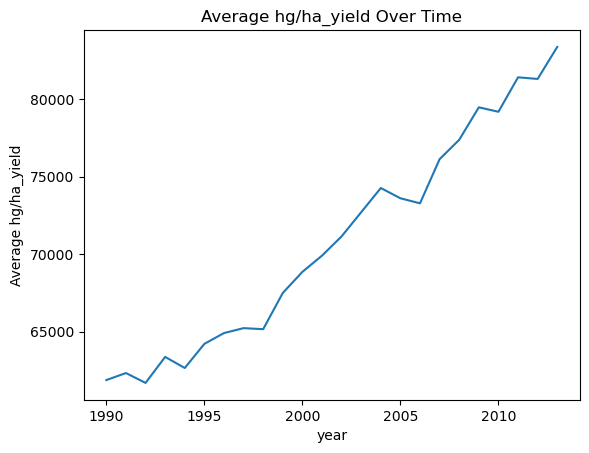

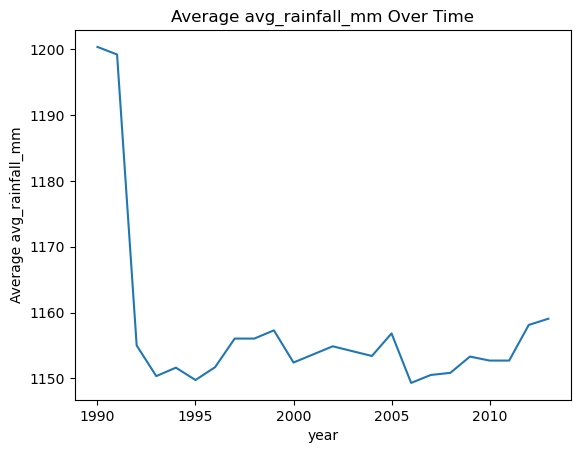

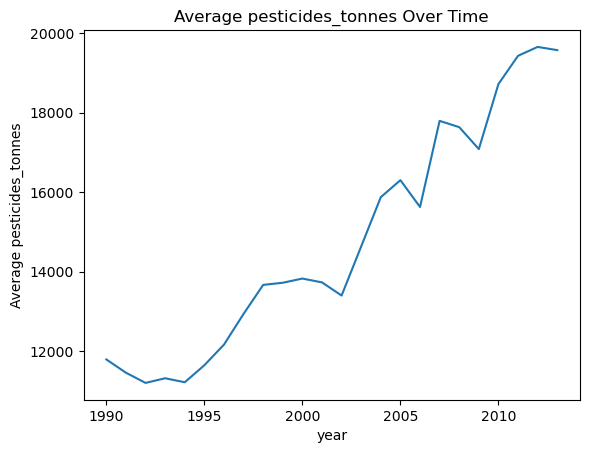

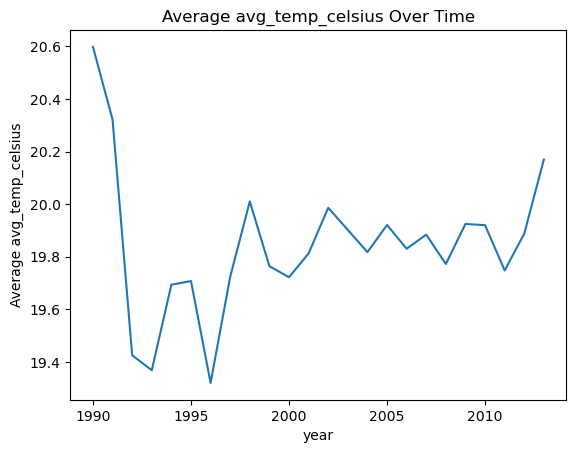

In [72]:
for column in measured_columns:
    df.groupby('year')[column].mean().plot()
    plt.title(f'Average {column} Over Time')
    plt.xlabel('year')
    plt.ylabel(f'Average {column}')
    plt.show()

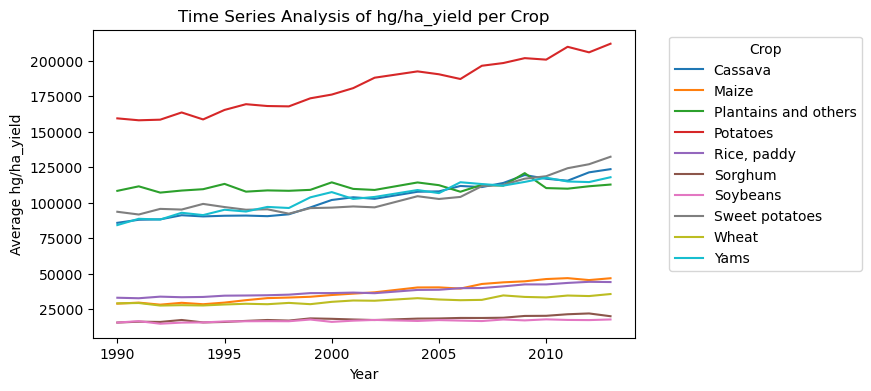

In [73]:
# Group by item and year, then calculate the mean hg/ha_yield
yield_per_crop_per_year = df.groupby(['item', 'year'])['hg/ha_yield'].mean().unstack()

# Plot the time series for each crop
plt.figure(figsize=(7, 4))
for crop in yield_per_crop_per_year.index:
    plt.plot(yield_per_crop_per_year.columns, yield_per_crop_per_year.loc[crop], label=crop)

plt.title('Time Series Analysis of hg/ha_yield per Crop')
plt.xlabel('Year')
plt.ylabel('Average hg/ha_yield')
plt.legend(title='Crop', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Analysis of Yield to Entities

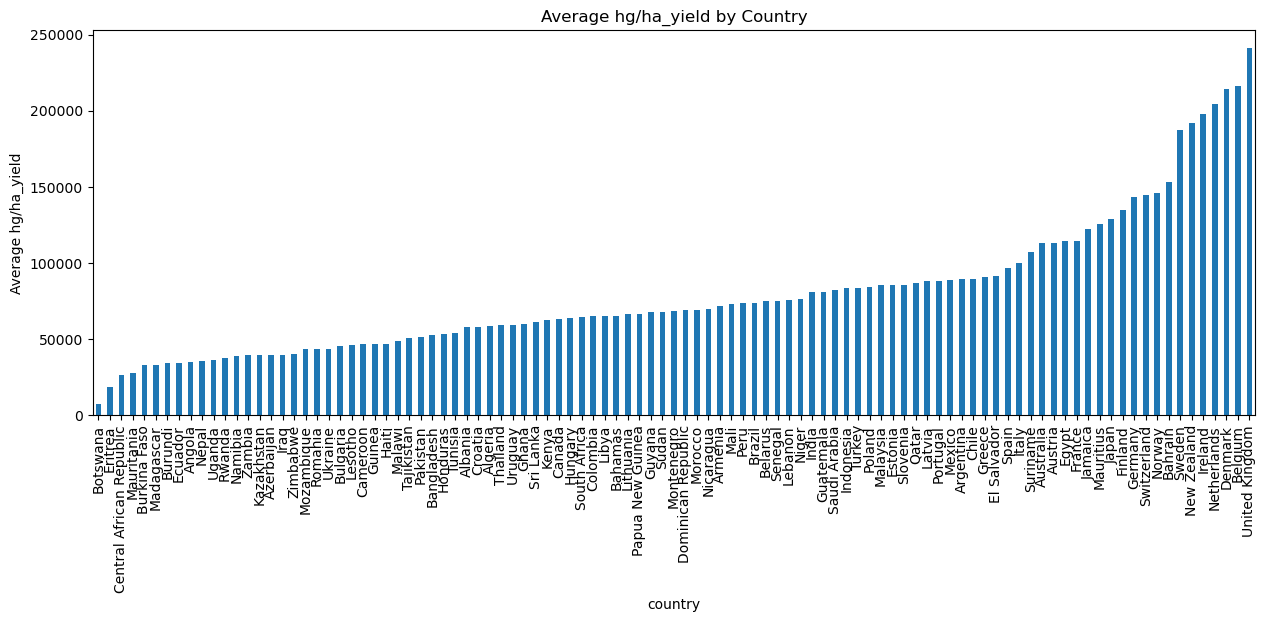

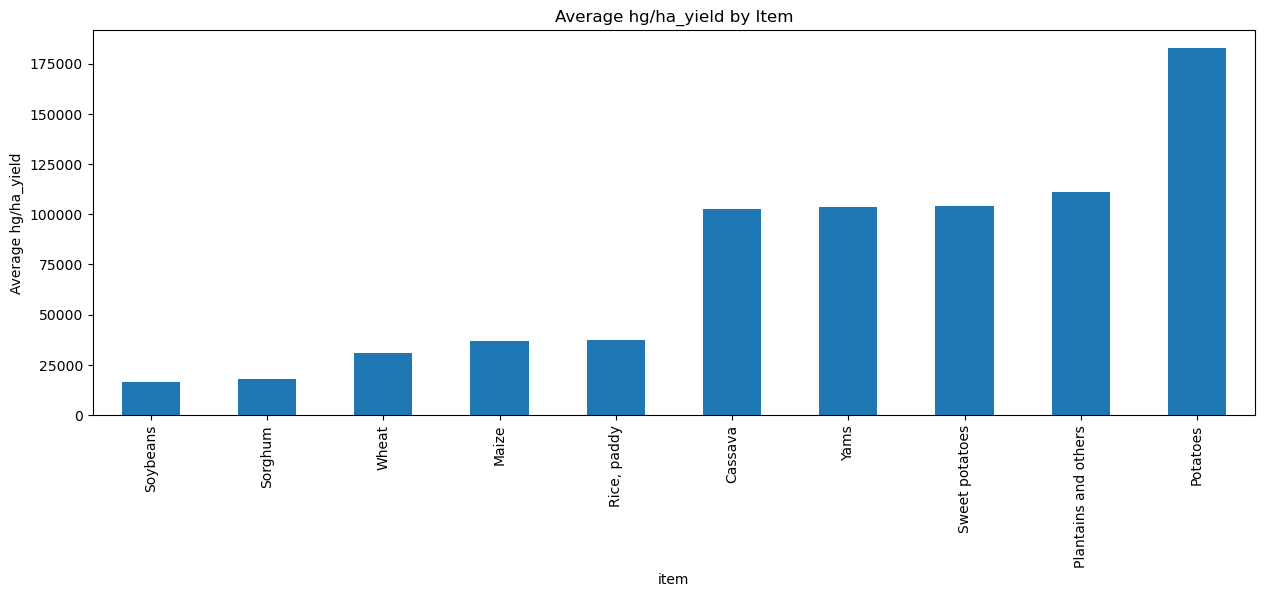

In [94]:
for column in entity_columns:
    df.groupby(column)['hg/ha_yield'].mean().sort_values().plot(kind='bar', figsize=(15, 5))
    plt.title(f'Average hg/ha_yield by {column.capitalize()}')
    plt.xlabel(column)
    plt.ylabel('Average hg/ha_yield')
    plt.show()

Heatmap

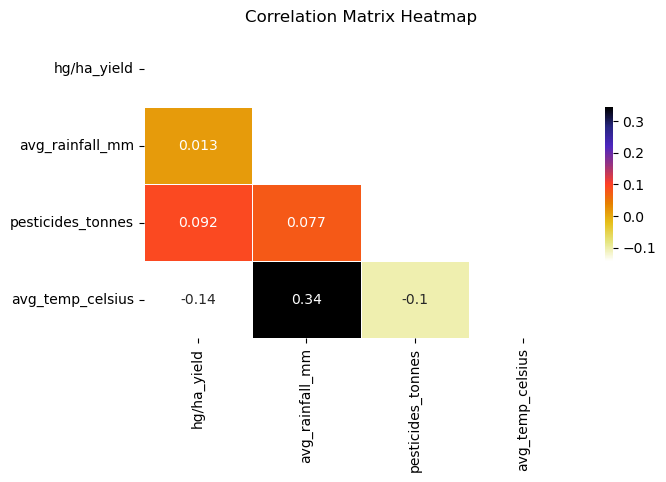

In [75]:
correlation_matrix = df[measured_columns].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(7, 4))
sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.CMRmap_r, mask=mask, linewidths=0.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix Heatmap')
plt.show()

Pairplot

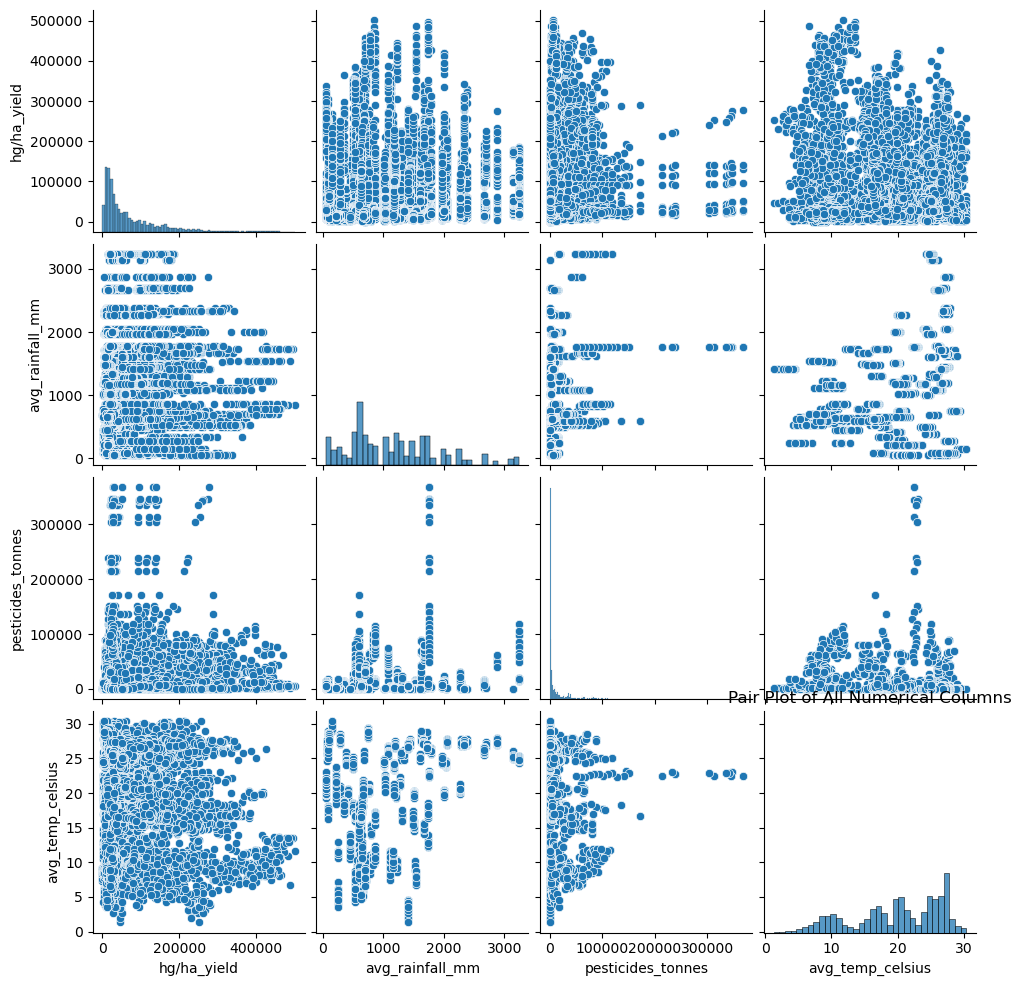

In [76]:
sns.pairplot(df[measured_columns])
plt.title('Pair Plot of All Numerical Columns')
plt.show()

#### 6. Apply machine learning

Encode and split data

In [77]:
# One hot encode categorical variables
df_model = df.copy()
df_model = pd.get_dummies(df, columns=['country', 'item'])

# Drop year as it is not a feature
X = df_model.drop(columns=['year'])
X = df_model.drop(columns=['hg/ha_yield'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Y = df_model['hg/ha_yield']

X_train, X_test, y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)


Evaluate models

Decision Tree
MSE: 388580711.6531, RMSE: 19712.4507, R²: 0.9425


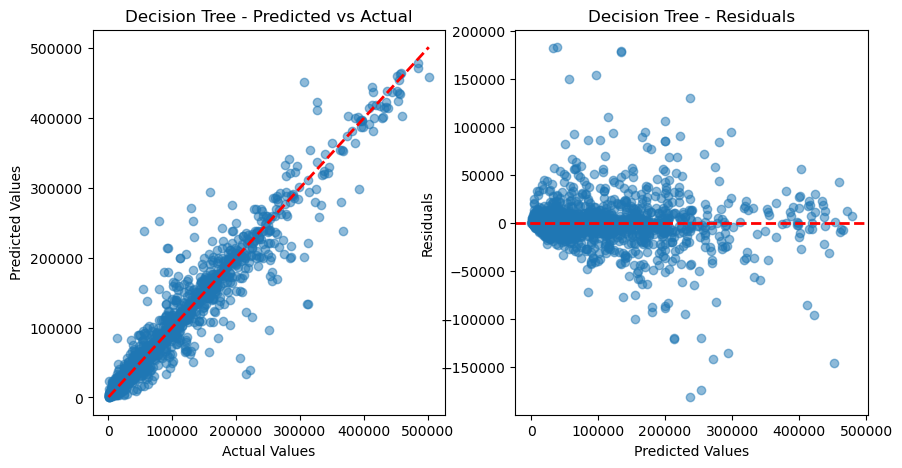

Random Forest
MSE: 225913849.5822, RMSE: 15030.4308, R²: 0.9666


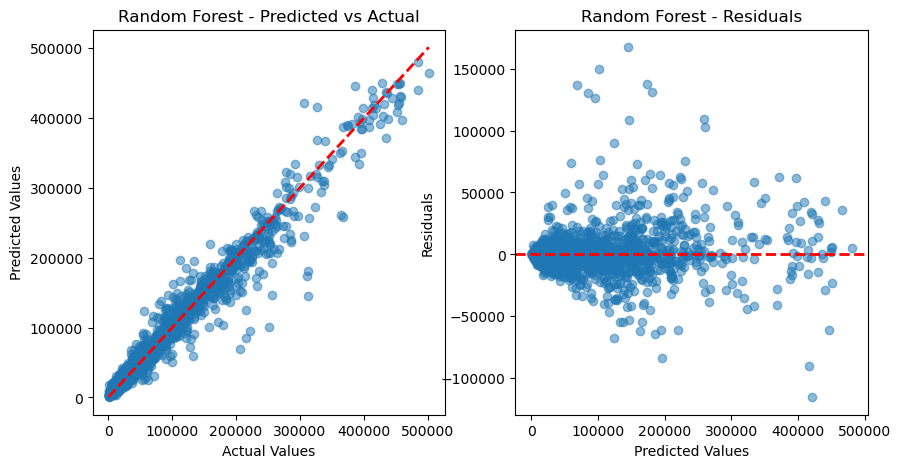

Gradient Boosting
MSE: 1237065535.2233, RMSE: 35171.9424, R²: 0.8170


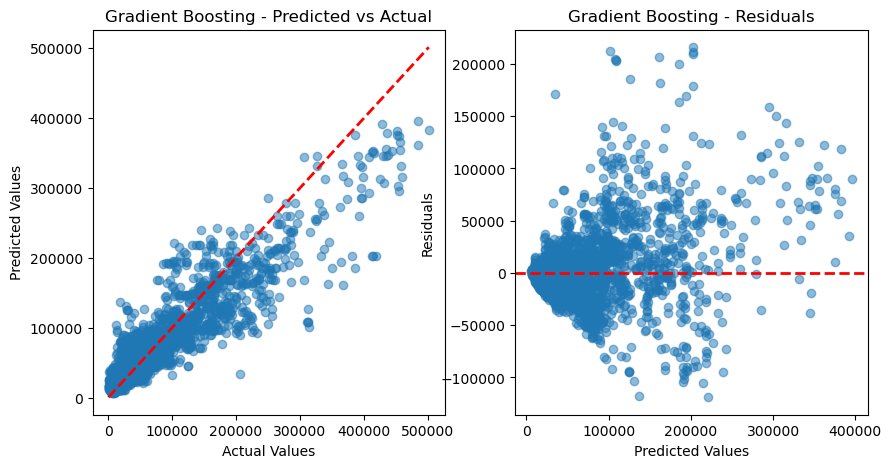

In [78]:
def evaluate_and_plot_model(model, model_name, X_test, Y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(Y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test, y_pred)

    print(f'{model_name}')
    print(f'MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}')

    # Predicted vs Actual values plot
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(Y_test, y_pred, alpha=0.5)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_name} - Predicted vs Actual')
    plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2)

    # Residuals plot
    residuals = Y_test - y_pred
    plt.subplot(1, 2, 2)
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} - Residuals')
    plt.axhline(y=0, color='r', linestyle='--', lw=2)

    plt.show()

decision_tree_regressor = DecisionTreeRegressor(random_state=42)
random_forest_regressor = RandomForestRegressor(random_state=42)
gradient_boosting_regressor = GradientBoostingRegressor(random_state=42)

decision_tree_regressor.fit(X_train, y_train)
random_forest_regressor.fit(X_train, y_train)
gradient_boosting_regressor.fit(X_train, y_train)

models = [decision_tree_regressor, random_forest_regressor, gradient_boosting_regressor]
model_names = ['Decision Tree', 'Random Forest', 'Gradient Boosting']

for model, name in zip(models, model_names):
    evaluate_and_plot_model(model, name, X_test, Y_test)

                 Feature  Importance
108        item_Potatoes    0.377374
1      pesticides_tonnes    0.115798
3       avg_temp_celsius    0.091227
2        avg_rainfall_mm    0.084961
112  item_Sweet potatoes    0.048574
..                   ...         ...
8        country_Armenia    0.000030
34       country_Estonia    0.000015
17      country_Botswana    0.000011
97       country_Tunisia    0.000011
67    country_Montenegro    0.000010

[115 rows x 2 columns]


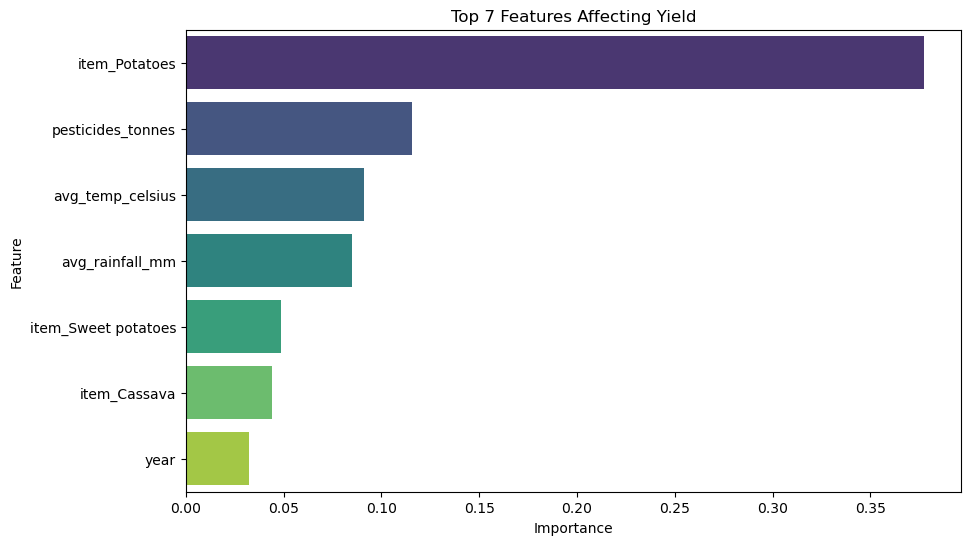

In [79]:
importances = random_forest_regressor.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.nlargest(7, 'Importance'), hue='Feature', palette='viridis', legend=False)
plt.title('Top 7 Features Affecting Yield')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Sample Prediction

In [80]:
sample_size = 10
X_test_sample = X_test[:sample_size]

Y_pred_sample = random_forest_regressor.predict(X_test_sample)
Y_actual_sample = Y_test[:sample_size]

df_sample = pd.DataFrame({
    'Predicted': Y_pred_sample,
    'Actual': Y_actual_sample.values
})

display(df_sample)

,Predicted,Actual
0,14388.99,15005
1,54723.89,57884
2,58273.61,56831
3,63129.90,62724
4,11716.57,6513
5,14068.38,14992
6,36498.12,35182
7,44812.74,45589
8,53156.35,38514
9,20420.86,19932
